# Import modules

In [1]:
import IO
import interface
import numpy as np
import matplotlib.pyplot as plt

# Setup variables

In [2]:
users = ['a', 'n', 'v']
users_colors = {'a': 'C0', 'n': 'C1', 'v': 'C2'}
users_names = {'a': 'Alexander', 'n': 'Nicolas', 'v': 'Viktor'}
orbits = range(1, 3190)
r_v = 6052  # km, Venus radii

boundary_location = ['inbound', 'outbound']
boundary_prepost = ['pre', 'post']

In [3]:
# Import user dictionaries

# Alex
a_region = IO.read_file(filepath='regions', filename='region_a')
a_dict = a_region.get()

# Nicolas
n_region = IO.read_file(filepath='regions', filename='region_n')
n_dict = n_region.get()

# Viktor
v_region = IO.read_file(filepath='regions', filename='region_v')
v_dict = v_region.get()

user_dicts = [a_dict, n_dict, v_dict]

# Import spice kernels

In [4]:
import spiceypy as spice
from irfpy.vexpvat import vexspice as vspice
import irfpy.vexpvat.frame
vspice.init()
spice.furnsh('/Volumes/VenusEnvy/VExData/spice/kernels/lsk/NAIF0010.TLS')

# Setup plotting functions

In [5]:

def BowShock_IMB(x0, x1, half=False):
    """Defines the IMB and Bow shock position for a given x range. Adapted from Martinecz et al. [2008]."""
    import matplotlib.patches as patch
    import numpy as np
    # IMB calculation
    x_lims = np.arange(x0 - 0.01, x1 + 0.01, 0.01)
    IMB = []
    for x in x_lims:
        k = -0.097
        d = 1.109
        if x <= 0.:
            r = k * x + d
        elif 0. < x <= d:
            # A circle with radius 1.109
            r = np.sqrt(d * d - x * x)
        else:
            r = 0.
        IMB.append(r)
    IMB = np.array(IMB)
    if not half:
        IMB_circle = patch.Arc((0, 0), 2 * 1.109, 2 * 1.109, angle=0.0, theta1=0.0, theta2=90.0, color='k', lw=5, ls='--')
    else:
        IMB_circle = patch.Arc((0, 0), 2 * 1.109, 2 * 1.109, angle=0.0, theta1=-90.0, theta2=90.0, color='k', lw=5, ls='--')

    # Bow Shock calculation
    l = 1.303
    e = 1.056
    xref = 0.788
    angle = np.arange(0, 180, 0.01) * np.pi / 180
    BS_radius = l / (1 + e * np.cos(angle))
    BS_x = BS_radius * np.cos(angle) + xref
    BS_y = BS_radius * np.sin(angle)
    BS = np.array([BS_x[BS_x < BS_radius + xref], BS_y[BS_x < BS_radius + xref]])

    return IMB, IMB_circle, BS, x_lims


def plot_venus_bs_imb(ax):
    import matplotlib.pyplot as plt
    circle = plt.Circle((0, 0), 1, color='k', fill=False, lw=5)
    ax.add_artist(circle)

    ICB_line, ICB_circle, BS, x_lims = BowShock_IMB(-6, 0, half=True)
    ax.plot(x_lims, ICB_line, '--k', lw=2)
    ax.plot(BS[0, :], BS[1, :], 'k', lw=2)
    ax.add_artist(ICB_circle)

    ax.plot(x_lims, -ICB_line, '--k', lw=2)
    ax.plot(BS[0, :], -BS[1, :], 'k', lw=2)
    ax.add_artist(ICB_circle)


def plot_venus_bs_imb_yz(ax):
    import matplotlib.pyplot as plt
    # Plot the Venus surface
    circle_venus = plt.Circle((0, 0), 1, color='k', fill=False, lw=5)
    ax.add_artist(circle_venus)

    # Plot the Bow shock and IMB at the terminator
    IMB_circle = plt.Circle((0, 0), 1.109, color='k', ls='--', fill=False, lw=5)
    BS_circle = plt.Circle((0, 0), 2.091, color='g', ls='-', fill=False, lw=5)
    ax.add_artist(IMB_circle)
    ax.add_artist(BS_circle)



# Functions for calculating averages of pre and post boundary determinations

In [6]:
def pre_post_average_location(timesDt):
    position_vex = []
    for timeDt in timesDt:
        posvel = vspice.get_posvel(timeDt, target='VEX', origin='VENUS', frame='VSO')
        position_vex.append(posvel[:3] / r_v)  # Venus radii unit
        # velocity_vex = posvel[3:] * 1e3  # m/s
    position_vex = np.array(position_vex)
    pos_diff = np.abs(np.sqrt(np.sum(position_vex[0, :]**2)) - np.sqrt(np.sum(position_vex[1, :]**2)))
#     if pos_diff * r_v < 1000:
    pos_x = np.nanmean(position_vex[:, 0])
    pos_y = np.nanmean(position_vex[:, 1])
    pos_z = np.nanmean(position_vex[:, 2])
    pos_r = np.sqrt(pos_y**2 + pos_z**2)
    return pos_x, pos_r, pos_diff

# Bow Shock

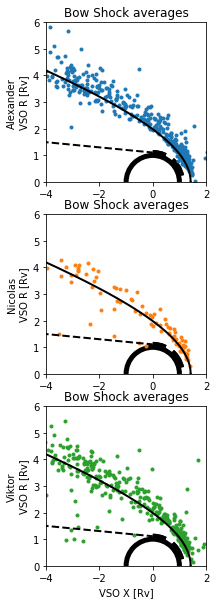

inbound_a 196
inbound_n 44
inbound_v 190
outbound_a 195
outbound_n 44
outbound_v 188


In [7]:
boundary_name = 'bow shock'
fig, AX = plt.subplots(3, 1, figsize=(16, 10))
users_orbits = {}
for b_l in boundary_location:
    for user_id in range(3):
        user_orbits = 0
        pos_x = []
        pos_r = []
        pos_diff = []
        for orbit in orbits:
            timesDt = []
            for b_pp in boundary_prepost:
                boundary = b_l + ' ' + b_pp + ' ' + boundary_name
                try:
                    timesDt.append(user_dicts[user_id][orbit][boundary])
                except KeyError:
                    continue
            if len(timesDt) < 2:
                continue
            px, pr, pdiff = pre_post_average_location(timesDt)
            pos_x.append(px)
            pos_r.append(pr)
            pos_diff.append(pdiff)
            user_orbits += 1
        users_orbits[b_l + '_' + users[user_id]] = user_orbits
        users_orbits[b_l + '_' + users[user_id] + '_' + 'pdiff'] = np.array(pos_diff)
        AX[user_id].plot(pos_x, pos_r, '.', color=users_colors[users[user_id]])
        
        
for idx, ax in enumerate(AX.ravel()):
    plot_venus_bs_imb(ax)  # Add the theoretical boundaries from Martinecz et al., 2008, and the Venus disk
    ax.set_ylim(0., 6.)
    ax.set_xlim(-4., 2.)
    ax.set_aspect('equal')
    ax.set_title('Bow Shock averages')
    ax.set_ylabel('{}\nVSO R [Rv]'.format(users_names[users[idx]]))
AX[-1].set_xlabel('VSO X [Rv]')

plt.show()    

for b_l in boundary_location:
    for user_id in range(3):
        print(b_l + '_' + users[user_id], users_orbits[b_l + '_' + users[user_id]])

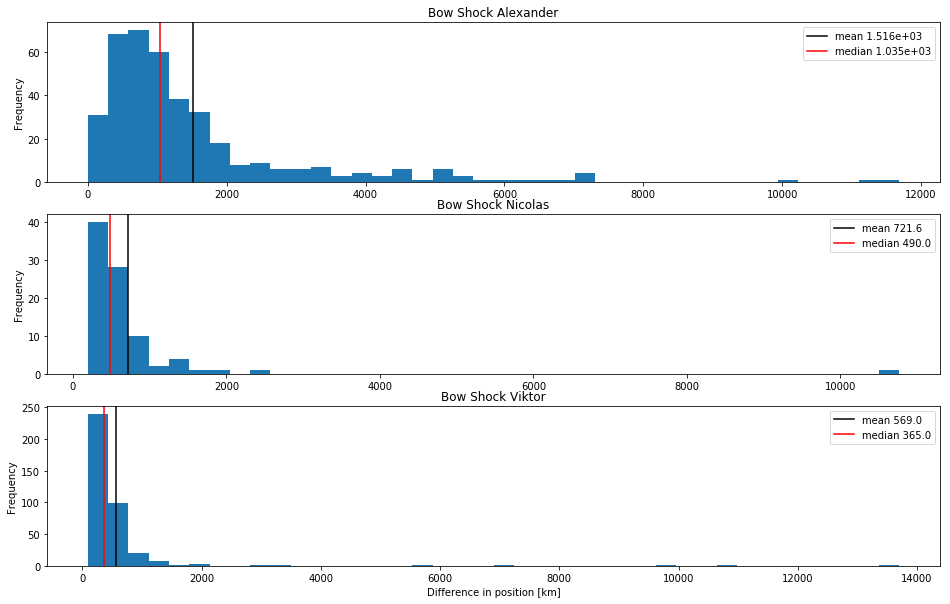

In [8]:
# Plot statistics of how much pre and post differs for each user
fig, AX = plt.subplots(3, 1, figsize=(16, 10))
for user_id in range(3):
    pdiff = []
    for b_l in boundary_location:
        pdiff.extend(users_orbits[b_l + '_' + users[user_id] + '_' + 'pdiff'] * r_v)
    AX[user_id].hist(pdiff, bins=40)
    AX[user_id].axvline(x=np.mean(pdiff), c='k', label='mean {:.4}'.format(np.mean(pdiff)))
    AX[user_id].axvline(x=np.median(pdiff), c='r', label='median {:.4}'.format(np.median(pdiff)))

for idx, ax in enumerate(AX.ravel()):
    ax.set_title('Bow Shock ' + users_names[users[idx]])
    ax.set_ylabel('Frequency')
    ax.legend()
AX[-1].set_xlabel('Difference in position [km]')

plt.show()


# Ion Composition Boundary

In [ ]:
boundary_name = 'ion composition boundary'
fig, AX = plt.subplots(3, 1, figsize=(16, 10))
users_orbits = {}
for b_l in boundary_location:
    for user_id in range(3):
        user_orbits = 0
        pos_x = []
        pos_r = []
        for orbit in orbits:
            timesDt = []
            for b_pp in boundary_prepost:
                boundary = b_l + ' ' + b_pp + ' ' + boundary_name
                try:
                    timesDt.append(user_dicts[user_id][orbit][boundary])
                except KeyError:
                    continue
            if len(timesDt) < 2:
                continue
            px, pr, pdiff = pre_post_average_location(timesDt)
            pos_x.append(px)
            pos_r.append(pr)
            pos_diff.append(pdiff)
            user_orbits += 1
        users_orbits[b_l + '_' + users[user_id]] = user_orbits
        users_orbits[b_l + '_' + users[user_id] + '_' + 'pdiff'] = np.array(pos_diff)
        AX[user_id].plot(pos_x, pos_r, '.', color=users_colors[users[user_id]])

for idx, ax in enumerate(AX.ravel()):
    plot_venus_bs_imb(ax)  # Add the theoretical boundaries from Martinecz et al., 2008, and the Venus disk
    ax.set_ylim(0., 6.)
    ax.set_xlim(-4., 2.)
    ax.set_aspect('equal')
    ax.set_title('Ion Composition Boundary averages')
    ax.set_ylabel('{}\nVSO R [Rv]'.format(users_names[users[idx]]))
AX[-1].set_xlabel('VSO X [Rv]')

plt.show()

for b_l in boundary_location:
    for user_id in range(3):
        print(b_l + '_' + users[user_id], users_orbits[b_l + '_' + users[user_id]])

In [ ]:
# Plot statistics of how much pre and post differs for each user
fig, AX = plt.subplots(3, 1, figsize=(16, 10))
for user_id in range(3):
    pdiff = []
    for b_l in boundary_location:
        pdiff.extend(users_orbits[b_l + '_' + users[user_id] + '_' + 'pdiff'] * r_v)
    AX[user_id].hist(pdiff, bins=40)
    AX[user_id].axvline(x=np.mean(pdiff), c='k', label='mean {:.4}'.format(np.mean(pdiff)))
    AX[user_id].axvline(x=np.median(pdiff), c='r', label='median {:.4}'.format(np.median(pdiff)))

for idx, ax in enumerate(AX.ravel()):
    ax.set_title('Ion composition boundary ' + users_names[users[idx]])
    ax.set_ylabel('Frequency')
    ax.legend()
AX[-1].set_xlabel('Difference in position [km]')

plt.show()